In [2]:
import sys
sys.path.append("../../../") # Where to find utilssphering
import utilssphering
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [3]:
# Read CSV
match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,sphering,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.000144,True,0.191908,60.000000,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.288099,2014937
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.000144,False,0.269727,53.333333,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.320855,2014937
2,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,True,0.269617,62.222222,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.398249,2413350
3,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,False,0.329074,45.555556,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.389170,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,...,0.000142,True,0.205121,66.666667,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.363114,2381443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,...,0.000583,False,0.628379,20.000000,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",6.976744,0.772160,489099
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,True,0.139090,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.193171,452567
359,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,False,0.666818,21.111111,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",9.302326,0.790813,452567
360,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_40x,Confocal,9,4.0,1,40,6,...,0.080201,True,0.193787,53.333333,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.234702,116595


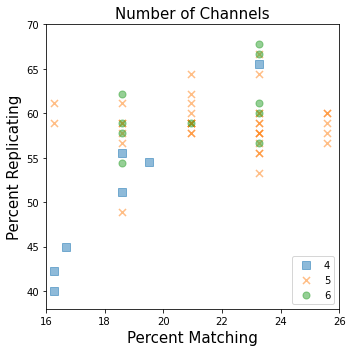

In [4]:
# A 

group = "Number_of_channels"

df_subset = match_rep_df[
    (match_rep_df["sphering"] == True) &
    (~match_rep_df["Batch"].str.contains("siteSub")) 
    ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=df_subset,
    x="Percent_Matching", 
    y="Percent_Replicating",
    group=group,
    fig=fig,
    ax_=ax,
    legend=True,
    legend_location="lower right",
    alpha=0.5,
    use_markers=True,
    s=50,
    x_lim=[16,26],
    y_lim=[38,70],
    plot_title="Number of Channels",
    xlabel="Percent Matching",
    ylabel="Percent Replicating"
)

        
fig.savefig("(A)-rep-vs-match-number_of_channels.png", dpi=300)

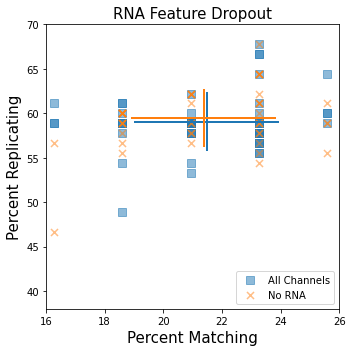

In [7]:
# B

rna_drop_df = pd.read_csv("../../../checkpoints/match_rep_df-RNA-DROP.csv")

# Process the dropout column for plotting
rna_drop_df['dropout'] = rna_drop_df['dropout'].replace("()", "All Channels").replace("('RNA',)", "No RNA")


group = "dropout"

df_subset = rna_drop_df[
    (rna_drop_df["sphering"] == True) &
    # Drop runs on all profiles, including those that don't even have an RNA channel
    # (not ideal, but saves time re-running)
    # So only plot profiles that did acquire the RNA channel
    (rna_drop_df["channel_names"].str.contains("RNA")) &
    (~rna_drop_df["Batch"].str.contains("siteSub")) 
    ]

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig,
    ax_=ax
)
utilssphering.group_plot(
    df_subset, 
    x="Percent_Matching", 
    y="Percent_Replicating", 
    group=group, 
    fig=fig, 
    ax_=ax, 
    legend=True,
    legend_location="lower right",
    alpha=0.5,
    use_markers=True,
    s=50,
    x_lim=[16,26],
    y_lim=[38,70],
    plot_title="RNA Feature Dropout",
    xlabel="Percent Matching",
    ylabel="Percent Replicating"
)

fig.savefig("(B)-rep-vs-match-RNA-dropout.png", dpi=300)